<h1> Preprocessing & Datenanalyse - Notebook

In [ ]:
# ============================
# Standardbibliotheken
# ============================
import os
import shutil
import random
from pathlib import Path
from collections import Counter, defaultdict

# ============================
# Third-Party: Core & Utils
# ============================
import numpy as np
import pandas as pd
from tqdm import tqdm

# ============================
# Bildverarbeitung & Visualisierung
# ============================
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ============================
# Machine Learning / Evaluation
# ============================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# ============================
# Deep Learning (TensorFlow / Keras)
# ============================
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# ============================
# Optional: Kaggle (nur falls du das Dataset direkt ziehst)
# ============================
import kagglehub

# ============================
# Allgemeine Settings
# ============================
warnings.filterwarnings("ignore")

# Optional: Reproduzierbarkeit
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

<h1> Download Datasets

Wir laden die beiden Datasets 
- https://www.kaggle.com/datasets/mstjebashazida/affectnet/data
- https://www.kaggle.com/datasets/msambare/fer2013?resource=download

runter und speichern sie im Ordner Raw Data.
Da hier 60k Bilder geladen werden, dauert es etwas.

In [2]:
# =========================================================
# Pfade
# =========================================================

RAW_DATA = "../Raw Data"

AFFECTNET_FOLDER = os.path.join(RAW_DATA, "AffectNet")
FER_FOLDER       = os.path.join(RAW_DATA, "FER-2013")


# =========================================================
# Ordner sicher löschen (Windows-kompatibel)
# =========================================================

def reset_folder(path: str):
    """Löscht einen Ordner komplett und legt ihn neu an (Windows-fix)."""

    def remove_readonly(func, path, _):
        os.chmod(path, 0o777)
        func(path)

    if os.path.exists(path):
        shutil.rmtree(path, onerror=remove_readonly)

    os.makedirs(path, exist_ok=True)


# =========================================================
# Hilfsfunktionen
# =========================================================

def find_root_with_subdirs(base_dir: str, required_subdirs):
    """
    Durchsucht rekursiv base_dir und gibt den ersten Ordner zurück,
    der alle required_subdirs enthält (z.B. ["Train","Test"] oder ["train","test"])
    """
    required_subdirs = set(required_subdirs)
    for root, dirs, files in os.walk(base_dir):
        if required_subdirs.issubset(set(dirs)):
            return root
    return None


def copy_with_progress(src_root: str, dst_root: str, desc: str = "Copying"):
    """
    Kopiert alle Dateien rekursiv von src_root nach dst_root.
    Zeigt eine Progress-Bar.
    """

    file_list = []
    for root, dirs, files in os.walk(src_root):
        for f in files:
            src_path = os.path.join(root, f)
            rel_path = os.path.relpath(src_path, src_root)
            file_list.append((src_path, rel_path))

    for src_path, rel_path in tqdm(file_list, desc=desc, unit="file"):
        dst_path = os.path.join(dst_root, rel_path)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy2(src_path, dst_path)


# =========================================================
# 1. AFFECTNET
# =========================================================

print("📥 Downloading AffectNet via kagglehub...")
affectnet_dl_path = kagglehub.dataset_download("mstjebashazida/affectnet")
print("AffectNet downloaded to:", affectnet_dl_path)

affectnet_src_root = find_root_with_subdirs(affectnet_dl_path, ["Train", "Test"])
if affectnet_src_root is None:
    raise RuntimeError("❌ Konnte keinen AffectNet-Ordner mit 'Train' + 'Test' finden!")

print("🔁 Resetting target folder:", AFFECTNET_FOLDER)
reset_folder(AFFECTNET_FOLDER)

print("📂 Copying AffectNet into Raw Data/AffectNet ...")
copy_with_progress(affectnet_src_root, AFFECTNET_FOLDER, desc="AffectNet")


# =========================================================
# 2. FER-2013
# =========================================================

print("\n📥 Downloading FER-2013 via kagglehub...")
fer_dl_path = kagglehub.dataset_download("msambare/fer2013")
print("FER-2013 downloaded to:", fer_dl_path)

fer_src_root = find_root_with_subdirs(fer_dl_path, ["train", "test"])
if fer_src_root is None:
    raise RuntimeError("❌ Konnte keinen FER-2013-Ordner mit 'train' + 'test' finden!")

print("🔁 Resetting target folder:", FER_FOLDER)
reset_folder(FER_FOLDER)

print("📂 Copying FER-2013 into Raw Data/FER-2013 ...")
copy_with_progress(fer_src_root, FER_FOLDER, desc="FER-2013")


print("\n✅ All datasets downloaded and copied into 'Raw Data' successfully.")


📥 Downloading AffectNet via kagglehub...
AffectNet downloaded to: C:\Users\mario\.cache\kagglehub\datasets\mstjebashazida\affectnet\versions\1
🔁 Resetting target folder: ../Raw Data\AffectNet
📂 Copying AffectNet into Raw Data/AffectNet ...


AffectNet: 100%|██████████| 30627/30627 [00:41<00:00, 732.17file/s]



📥 Downloading FER-2013 via kagglehub...
FER-2013 downloaded to: C:\Users\mario\.cache\kagglehub\datasets\msambare\fer2013\versions\1
🔁 Resetting target folder: ../Raw Data\FER-2013
📂 Copying FER-2013 into Raw Data/FER-2013 ...


FER-2013: 100%|██████████| 35887/35887 [00:49<00:00, 718.12file/s]


✅ All datasets downloaded and copied into 'Raw Data' successfully.


<h1> Raw Data analysieren

Im ersten Schritt analysieren wir die beiden Datasets.
Wir betrachten
- Anzahl an Bilder pro Klasse
- Pixel pro Bild
- Beispielbilder pro Klasse
- Durchschnittliche Helligkeit pro Klasse

<h2> FER-2013 Dataset analysieren

In [3]:
DATASET_ROOT = "../Raw Data/FER-2013"
EMOTIONS = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
SPLITS = ["train", "test"]

<h3> Anzahl der Bilder pro Klasse

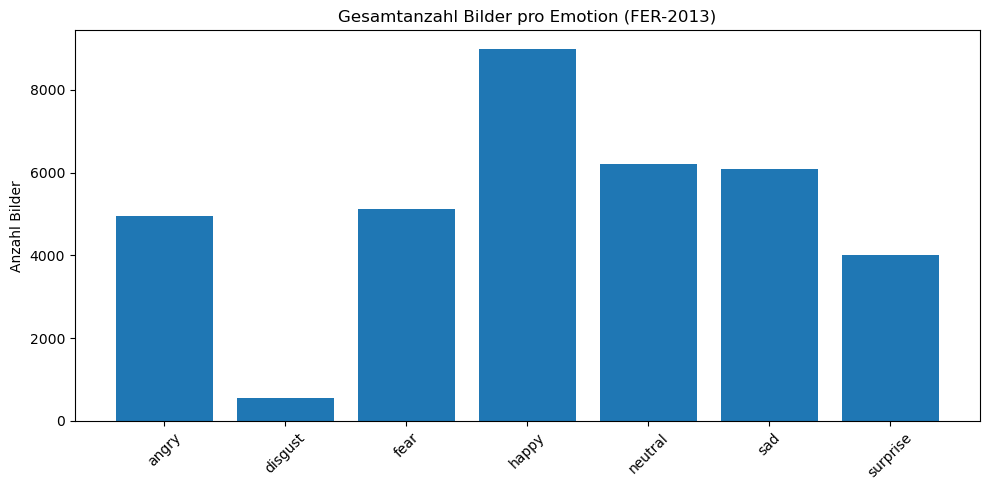

In [4]:
def count_total_images(dataset_root=DATASET_ROOT, splits=SPLITS, emotions=EMOTIONS):
    total_counts = defaultdict(int)

    # Zähle alle Bilder über train & test hinweg
    for split in splits:
        for emo in emotions:
            folder = os.path.join(dataset_root, split, emo)
            if not os.path.isdir(folder):
                print(f"[WARN] Ordner existiert nicht: {folder}")
                continue

            for fname in os.listdir(folder):
                if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    total_counts[emo] += 1

    # Sortiert in der Emotionen-Reihenfolge
    values = [total_counts[emo] for emo in emotions]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(emotions, values)
    plt.xticks(rotation=45)
    plt.ylabel("Anzahl Bilder")
    plt.title("Gesamtanzahl Bilder pro Emotion (FER-2013)")
    plt.tight_layout()
    plt.show()

    return total_counts


total_counts = count_total_images()


Auffällig ist, dass "disgust" nur wenige Samples enthält. Das könnte dazu führen, dass das Modell später Probleme hat "disgust" korrekt zu klassifizieren. Daher werden wir die Samples dieser Klasse später augmentieren.

<h3> Pixel pro Bild

In [5]:
def all_images_are_48x48(dataset_root="FER-2013"):
    for split in ["train", "test"]:
        split_path = os.path.join(dataset_root, split)

        if not os.path.isdir(split_path):
            continue

        for emo in os.listdir(split_path):
            emo_path = os.path.join(split_path, emo)
            if not os.path.isdir(emo_path):
                continue

            for fname in os.listdir(emo_path):
                if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    continue

                fpath = os.path.join(emo_path, fname)
                img = cv2.imread(fpath)

                if img is None:
                    return False

                h, w = img.shape[:2]
                if h != 48 or w != 48:
                    return False

    return True

# Ergebnis
if(all_images_are_48x48("FER-2013")):
    print("Alle Bilder sind 48x48 Pixel groß.")
else:
    print("Es gibt Bilder, die nicht 48x48 Pixel groß sind.")


Alle Bilder sind 48x48 Pixel groß.


Nun haben wir sichergestellt, dass alle Bilder die selbe Größe haben. Es ist also keine Anpassung nötig.

<h3> Beispielbilder pro Klasse

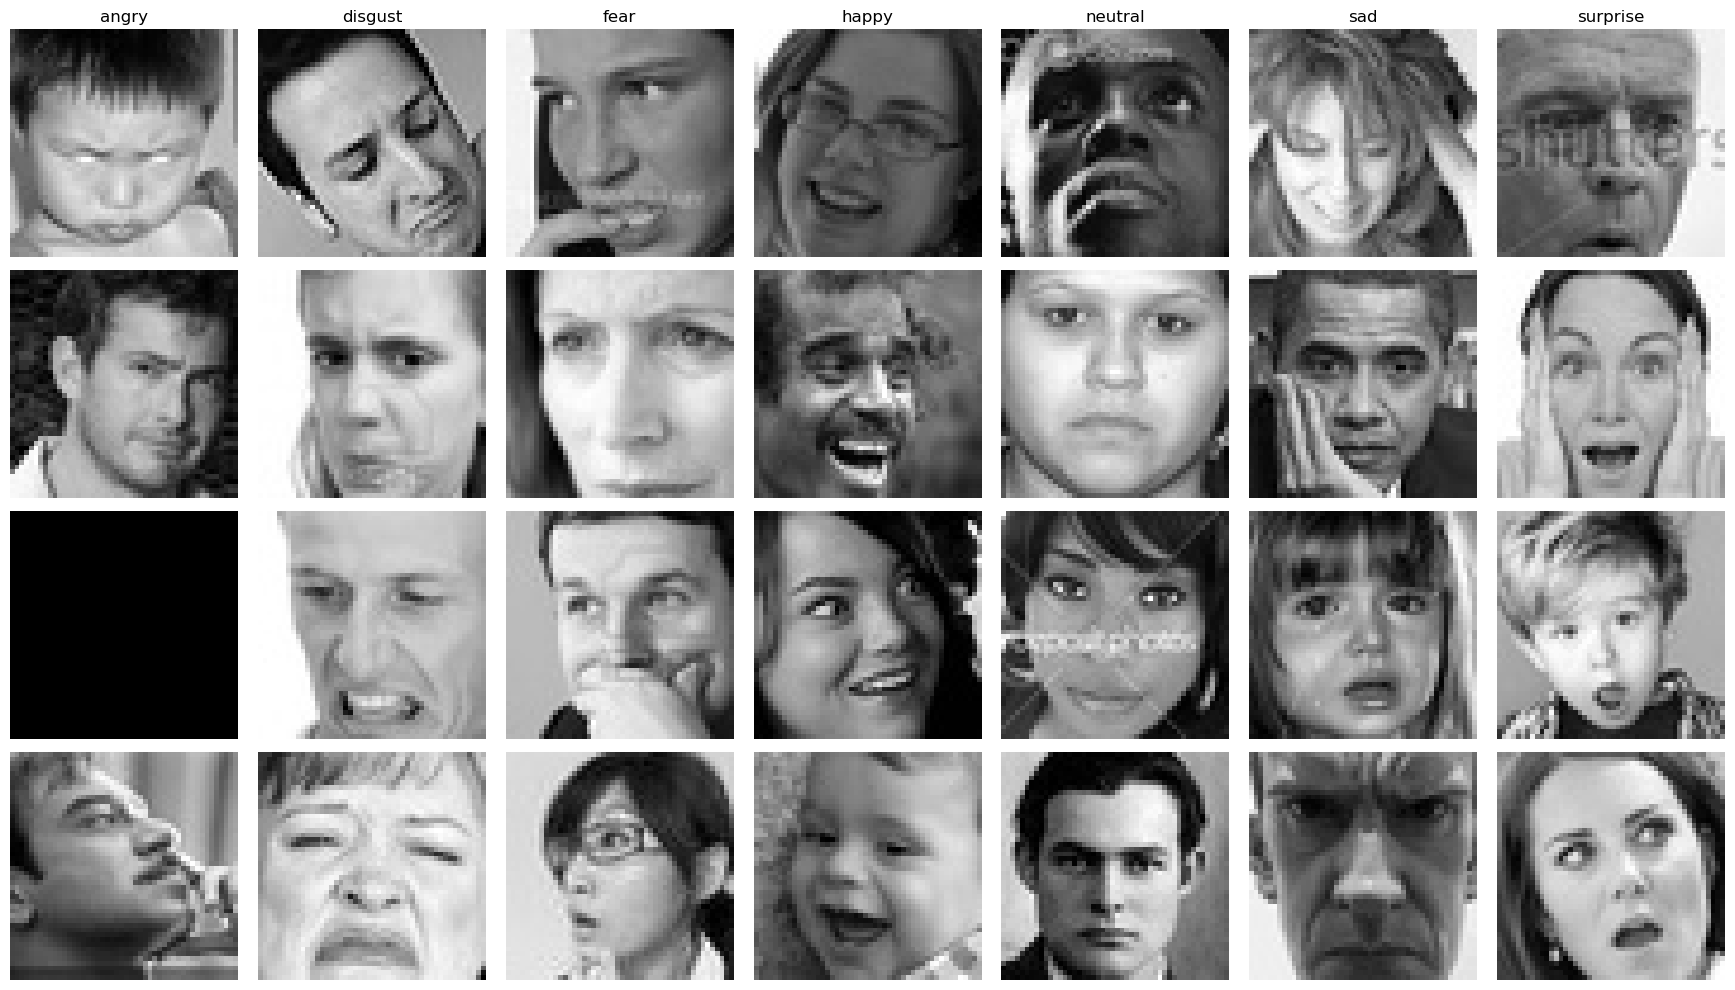

In [6]:
def get_example_paths_per_class(dataset_root=DATASET_ROOT, split="train",
                                emotions=EMOTIONS, n_examples=3):
    examples = {}

    for emo in emotions:
        folder = os.path.join(dataset_root, split, emo)
        if not os.path.isdir(folder):
            print(f"[WARN] Ordner existiert nicht: {folder}")
            continue

        img_files = [f for f in os.listdir(folder)
                     if f.lower().endswith((".png", ".jpg", ".jpeg"))]

        if len(img_files) == 0:
            print(f"[WARN] Keine Bilder in: {folder}")
            continue

        chosen = img_files[:n_examples]  # oder np.random.choice
        examples[emo] = [os.path.join(folder, f) for f in chosen]

    return examples


def plot_examples_grid(examples_dict, grayscale=True):
    emotions = list(examples_dict.keys())
    n_classes = len(emotions)              # 7 Spalten
    n_examples = len(next(iter(examples_dict.values())))  # 3 Zeilen

    plt.figure(figsize=(n_classes * 2.5, n_examples * 2.5))

    for col, emo in enumerate(emotions):
        paths = examples_dict[emo]

        for row, path in enumerate(paths):
            img = cv2.imread(path)
            if grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Position im Grid bestimmen
            plt.subplot(n_examples, n_classes, row * n_classes + col + 1)
            plt.imshow(img, cmap="gray" if grayscale else None)
            plt.axis("off")

            # Spaltentitel nur in der ersten Zeile
            if row == 0:
                plt.title(emo, fontsize=12)

    plt.tight_layout()
    plt.show()


# Beispielaufruf
examples = get_example_paths_per_class(split="train", n_examples=4)
plot_examples_grid(examples)

Auffällig ist das schware Bild. Wir werden später die Daten bereinigen,d amit so etwas nicht im Data Set enthalten ist.
Außerdem lässt sich über die Label streiten. Beispielsweise sieht die Person in Reihe 1 in Spalte "neutral" eher traurig als neutral aus. Die Daten sind also nicht optimal, was sich negativ auf die Precision auswirken wird.

<h3> Durchschnittliche Helligkeit pro Klasse

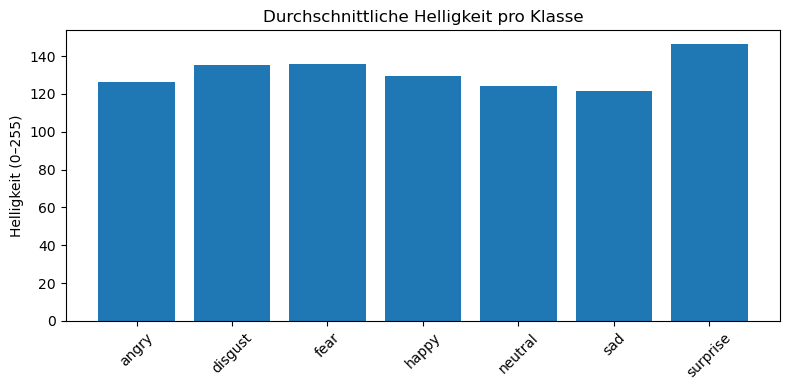

In [7]:
def avg_brightness_per_class(dataset_root=DATASET_ROOT, split="train", emotions=EMOTIONS):
    brightness = {}

    for emo in emotions:
        folder = os.path.join(dataset_root, split, emo)
        values = []

        for fname in os.listdir(folder):
            if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                img = cv2.imread(os.path.join(folder, fname), cv2.IMREAD_GRAYSCALE)
                values.append(np.mean(img))

        brightness[emo] = np.mean(values)

    plt.figure(figsize=(8,4))
    plt.bar(brightness.keys(), brightness.values())
    plt.title("Durchschnittliche Helligkeit pro Klasse")
    plt.ylabel("Helligkeit (0–255)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

avg_brightness_per_class()


Die Durchschnittliche Helligkeit ist überall ähnlcih. Das ist gut. Denn wenn sie bei einer Klasse auffällig abweichen würde, dann könnte das Modell lernen die Emotion anhand der Helligkeit, nicht anhand der Gestik abzuleiten.

<h2> AffectNet Dataset analysieren

In [8]:
AFFECTNET_ROOT = "../Raw Data/AffectNet"
SPLITS_AFF = ["Train", "Test"]

AFFECTNET_LABELS = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

<h3> Anzahl der Bilder pro Klasse

[INFO] Label 'contempt' (normalized='contempt') nicht in target_labels – skippe.
[INFO] Label 'Contempt' (normalized='contempt') nicht in target_labels – skippe.
=== Gesamtanzahl Bilder pro Klasse (AffectNet, Train+Test) ===
angry    : 3218
disgust  : 2477
fear     : 3176
happy    : 5044
neutral  : 5126
sad      : 4675
surprise : 4039

Gesamtanzahl Bilder: 27755


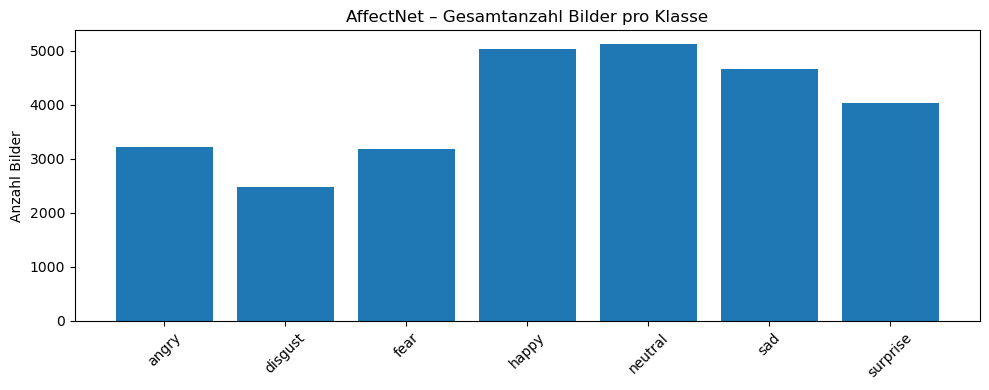

In [9]:
def normalize_affectnet_label(folder_name: str) -> str:
    """
    Mappt Ordnernamen auf ein einheitliches Label.
    z.B. 'Anger'/'anger' -> 'angry'
    """
    name = folder_name.lower()
    if name == "anger":
        return "angry"
    return name


def count_affectnet_images(dataset_root=AFFECTNET_ROOT,
                           splits=SPLITS_AFF,
                           target_labels=AFFECTNET_LABELS):
    total_counts = defaultdict(int)

    for split in splits:
        split_dir = os.path.join(dataset_root, split)
        if not os.path.isdir(split_dir):
            print(f"[WARN] Split-Ordner existiert nicht: {split_dir}")
            continue

        for folder in os.listdir(split_dir):
            folder_path = os.path.join(split_dir, folder)
            if not os.path.isdir(folder_path):
                continue

            label = normalize_affectnet_label(folder)

            if label not in target_labels:
                print(f"[INFO] Label '{folder}' (normalized='{label}') nicht in target_labels – skippe.")
                continue

            for fname in os.listdir(folder_path):
                if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    total_counts[label] += 1

    # Werte in fixer Reihenfolge
    counts_list = [total_counts[lbl] for lbl in target_labels]

    # Print
    print("=== Gesamtanzahl Bilder pro Klasse (AffectNet, Train+Test) ===")
    for lbl in target_labels:
        print(f"{lbl:9s}: {total_counts[lbl]}")
    print("\nGesamtanzahl Bilder:", sum(counts_list))

    # Plot
    x = np.arange(len(target_labels))
    plt.figure(figsize=(10, 4))
    plt.bar(x, counts_list)
    plt.xticks(x, target_labels, rotation=45)
    plt.ylabel("Anzahl Bilder")
    plt.title("AffectNet – Gesamtanzahl Bilder pro Klasse")
    plt.tight_layout()
    plt.show()

    return total_counts


# Aufruf
affectnet_counts = count_affectnet_images()

Anders als im ersten Dataset gibt es hier keine Klasse mit deutlich weniger Samples.

<h3> Pixel pro Bild

In [10]:
def all_affectnet_images_are_96x96(dataset_root=AFFECTNET_ROOT):
    for split in SPLITS_AFF:
        split_path = os.path.join(dataset_root, split)
        if not os.path.isdir(split_path):
            continue

        for clazz in os.listdir(split_path):
            class_dir = os.path.join(split_path, clazz)
            if not os.path.isdir(class_dir):
                continue

            for fname in os.listdir(class_dir):
                if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    continue

                path = os.path.join(class_dir, fname)
                img = cv2.imread(path)

                if img is None:
                    return False

                h, w = img.shape[:2]
                if w != 96 or h != 96:
                    return False

    return True

# Ergebnis ausgeben
if all_affectnet_images_are_96x96():
    print("Alle Bilder sind 96 x 96 Pixel groß")
else:
    print("Nicht alle Bilder sind 96 x 96 Pixel groß")


Alle Bilder sind 96 x 96 Pixel groß


Die Bilder sind in diesem Dataset größer als im ersten Dataset. Daher werden wir sie später downsizen.

<h3> Beispielbilder pro Klasse

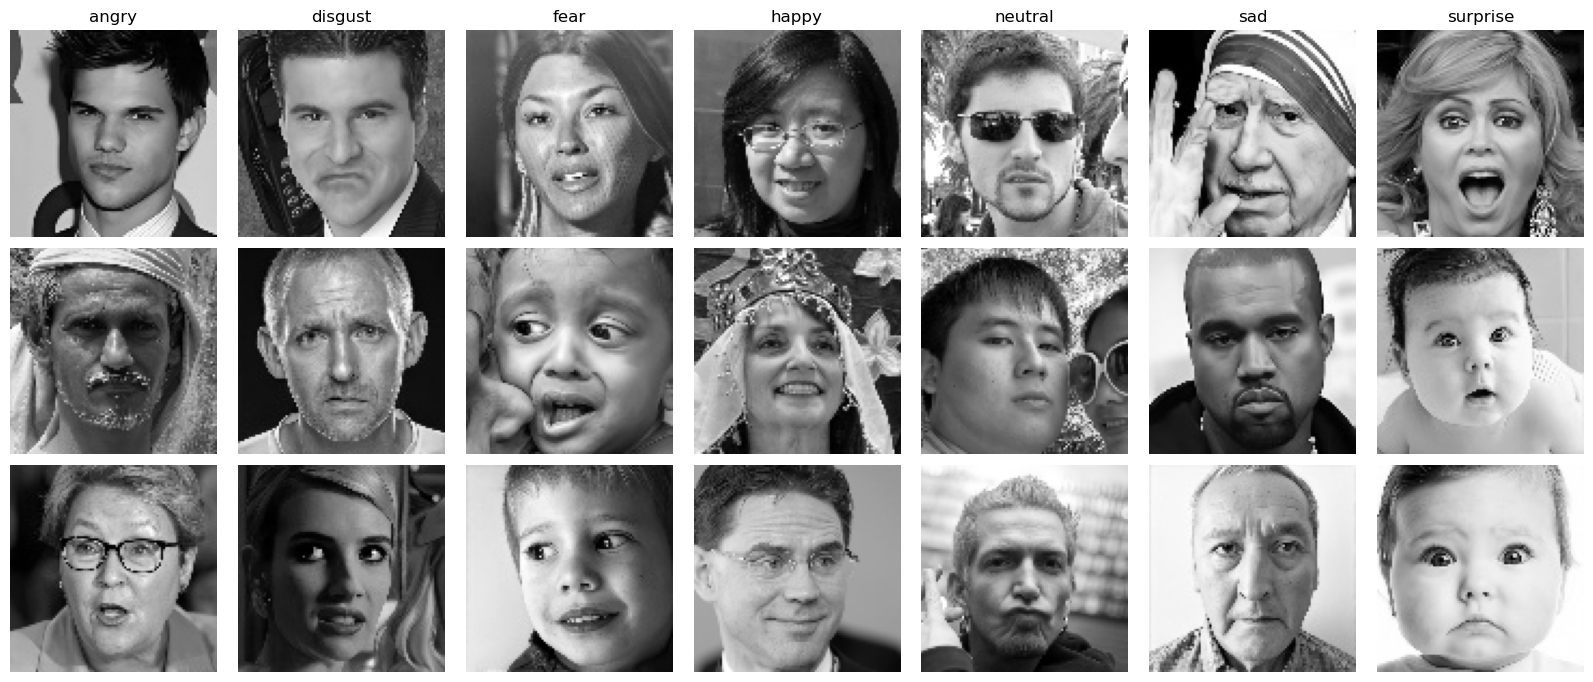

In [11]:
# Deine 7 Ziel-Emotionen
EMOTIONS_7 = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

def normalize_affectnet_label(folder_name: str) -> str:
    """Normalisiere AffectNet Klassen auf Zieldateinamen."""
    name = folder_name.lower()

    if name == "anger":
        return "angry"
    return name


def get_affectnet_examples(dataset_root=AFFECTNET_ROOT, split="Train", n_examples=3):
    examples = {emo: [] for emo in EMOTIONS_7}

    split_path = os.path.join(dataset_root, split)

    for folder in os.listdir(split_path):
        class_dir = os.path.join(split_path, folder)
        if not os.path.isdir(class_dir):
            continue

        label = normalize_affectnet_label(folder)

        # nur die 7 Hauptemotionen, contempt skippen
        if label not in EMOTIONS_7:
            continue

        files = [f for f in os.listdir(class_dir)
                 if f.lower().endswith((".png", ".jpg", ".jpeg"))]

        if len(files) == 0:
            continue

        chosen = files[:n_examples]

        examples[label] = [os.path.join(class_dir, f) for f in chosen]

    return examples


def plot_examples_affectnet(examples, grayscale=True):
    emotions = EMOTIONS_7                 # in fixer Reihenfolge
    n_classes = len(emotions)             # 7
    n_examples = 3                        # 3 Reihen

    plt.figure(figsize=(n_classes * 2.3, n_examples * 2.3))

    for col, emo in enumerate(emotions):
        paths = examples[emo]

        for row, path in enumerate(paths):

            img = cv2.imread(path)
            if img is None:
                continue

            if grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(n_examples, n_classes, row * n_classes + col + 1)
            plt.imshow(img, cmap="gray" if grayscale else None)
            plt.axis("off")

            # Titel nur oben
            if row == 0:
                plt.title(emo, fontsize=12)

    plt.tight_layout()
    plt.show()


# ========== AUSFÜHREN ==========
examples_affectnet = get_affectnet_examples(split="Train", n_examples=3)
plot_examples_affectnet(examples_affectnet)

Auch hier lässt sich über die Label streiten. Beispielsweise sieht die Person in Reihe 1 der Spalte angry nicht wirklich wütend aus.

<h3> Durchschnittliche Helligkeit pro Klasse

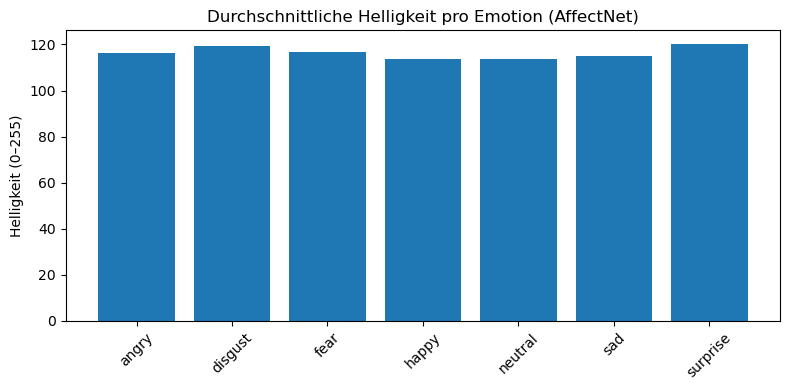

In [12]:
def normalize_affectnet_label(folder_name: str) -> str:
    name = folder_name.lower()

    if name == "anger":
        return "angry"
    if name == "contempt":
        return "contempt"  # wird ignoriert
    return name


def compute_mean_brightness_affectnet(dataset_root=AFFECTNET_ROOT,
                                      splits=SPLITS,
                                      emotions=EMOTIONS_7):
    brightness = {emo: [] for emo in emotions}

    for split in splits:
        split_path = os.path.join(dataset_root, split)

        for folder in os.listdir(split_path):
            class_path = os.path.join(split_path, folder)
            if not os.path.isdir(class_path):
                continue

            label = normalize_affectnet_label(folder)

            # nur 7 Klassen, contempt skippen
            if label not in emotions:
                continue

            files = [f for f in os.listdir(class_path)
                     if f.lower().endswith((".png", ".jpg", ".jpeg"))]

            for fname in files:
                fpath = os.path.join(class_path, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)

                if img is None:
                    continue

                brightness[label].append(np.mean(img))

    # Mittelwert je Klasse
    mean_brightness = {emo: np.mean(values) for emo, values in brightness.items()}

    # Plotten
    plt.figure(figsize=(8,4))
    plt.bar(mean_brightness.keys(), mean_brightness.values())
    plt.title("Durchschnittliche Helligkeit pro Emotion (AffectNet)")
    plt.ylabel("Helligkeit (0–255)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return mean_brightness


# --- AUSFÜHREN ---
mean_brightness_affectnet = compute_mean_brightness_affectnet()

Auch hier weicht die durchschnittliche Helligkeit keiner Klasse deutlich ab. Es ist also keine Anpassung nötig.

<h1> Datasets kombinieren

Nun wollen wir beide Datasets kombinieren. Da das FER-2013 Dataset nur Bilder mit 48 x 48 Pixel hat, verringern wir die Auflösung der Bilder aus dem AffectNet Dataset auf die selbe Größe. Anschließend speichern wir die Bilder beider Datasets in einen jeweiligen Klassen-Ordner

In [13]:
# --------------------------------------------------------
# Pfade
# --------------------------------------------------------

RAW_DATA = "../Raw Data"

AFFECTNET_ROOT = os.path.join(RAW_DATA, "AffectNet")
FER_ROOT       = os.path.join(RAW_DATA, "FER-2013")

OUTPUT_DIR = "../Preprocessing/Combined_48x48"

# Ziel-Emotionen
EMOTIONS = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]


# --------------------------------------------------------
# Hilfsfunktionen
# --------------------------------------------------------

def normalize_affectnet_label(folder_name: str) -> str:
    """AffectNet → Einheitliche 7 Klassen."""
    name = folder_name.lower()

    if name == "anger":
        return "angry"
    if name == "contempt":
        return None  # ignorieren
    return name  # disgust, fear, happy, neutral, sad, surprise


def ensure_clean_folder(path: str):
    """Ordner leeren + neu anlegen."""
    def remove_readonly(func, p, _):
        os.chmod(p, 0o777)
        func(p)

    if os.path.exists(path):
        shutil.rmtree(path, onerror=remove_readonly)

    os.makedirs(path, exist_ok=True)


def save_resized_jpg(src_path, dst_path, size=(48, 48)):
    img = cv2.imread(src_path)

    if img is None:
        return False

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)

    cv2.imwrite(dst_path, img, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
    return True


# --------------------------------------------------------
# Schritt 1: Output-Struktur anlegen
# --------------------------------------------------------

print("🔁 Resetting output folder...")
ensure_clean_folder(OUTPUT_DIR)

for emo in EMOTIONS:
    os.makedirs(os.path.join(OUTPUT_DIR, emo), exist_ok=True)

print("📁 Output-Struktur erstellt.")


# --------------------------------------------------------
# Schritt 2: FER-2013 verarbeiten
# --------------------------------------------------------

def process_fer(fer_root, out_root):
    print("\n📥 Verarbeite FER-2013...")

    count = 0
    for split in ["train", "test"]:
        split_path = os.path.join(fer_root, split)

        for emo in EMOTIONS:
            emo_dir = os.path.join(split_path, emo)
            if not os.path.isdir(emo_dir):
                continue

            files = [f for f in os.listdir(emo_dir)
                     if f.lower().endswith((".png", ".jpg", ".jpeg"))]

            for fname in tqdm(files, desc=f"FER {emo}", leave=False):
                src = os.path.join(emo_dir, fname)
                dst = os.path.join(out_root, emo, f"FER_{count}.jpg")

                if save_resized_jpg(src, dst):
                    count += 1

    print(f"FER-2013: {count} Bilder übernommen.")
    return count


# --------------------------------------------------------
# Schritt 3: AffectNet verarbeiten
# --------------------------------------------------------

def process_affectnet(aff_root, out_root):
    print("\n📥 Verarbeite AffectNet...")

    count = 0
    for split in ["Train", "Test"]:
        split_path = os.path.join(aff_root, split)
        if not os.path.isdir(split_path):
            continue

        for folder in os.listdir(split_path):
            class_dir = os.path.join(split_path, folder)
            if not os.path.isdir(class_dir):
                continue

            label = normalize_affectnet_label(folder)
            if label not in EMOTIONS:
                continue  # auch contempt skippen

            files = [f for f in os.listdir(class_dir)
                     if f.lower().endswith((".png", ".jpg", ".jpeg"))]

            for fname in tqdm(files, desc=f"AffectNet {label}", leave=False):
                src = os.path.join(class_dir, fname)
                dst = os.path.join(out_root, label, f"ANET_{count}.jpg")

                if save_resized_jpg(src, dst):
                    count += 1

    print(f"AffectNet: {count} Bilder übernommen.")
    return count


# --------------------------------------------------------
# AUSFÜHREN
# --------------------------------------------------------

fer_count = process_fer(FER_ROOT, OUTPUT_DIR)
aff_count = process_affectnet(AFFECTNET_ROOT, OUTPUT_DIR)

print("\n====================================================")
print(f" FER-2013  Bilder übernommen: {fer_count}")
print(f" AffectNet Bilder übernommen: {aff_count}")
print(" Gesamt:                       ", fer_count + aff_count)
print(" Fertig! Alle Bilder in /Combined_48x48 gespeichert.")
print("====================================================")

🔁 Resetting output folder...
📁 Output-Struktur erstellt.

📥 Verarbeite FER-2013...


FER-2013: 35887 Bilder übernommen.

📥 Verarbeite AffectNet...


AffectNet: 27755 Bilder übernommen.

 FER-2013  Bilder übernommen: 35887
 AffectNet Bilder übernommen: 27755
 Gesamt:                        63642
 Fertig! Alle Bilder in /Combined_48x48 gespeichert.


<h2> Kombiniertes Dataset Analysieren

Wir haben nun ein Dataset mit 7 Klassen und ca. 60k Bildern, welches wir nun analysieren.

<h3> Anzahl der Bilder pro Klasse

=== Anzahl Bilder pro Klasse (kombiniertes Dataset) ===
angry    : 8171
disgust  : 3024
fear     : 8297
happy    : 14033
neutral  : 11324
sad      : 10752
surprise : 8041

Gesamtanzahl Bilder: 63642


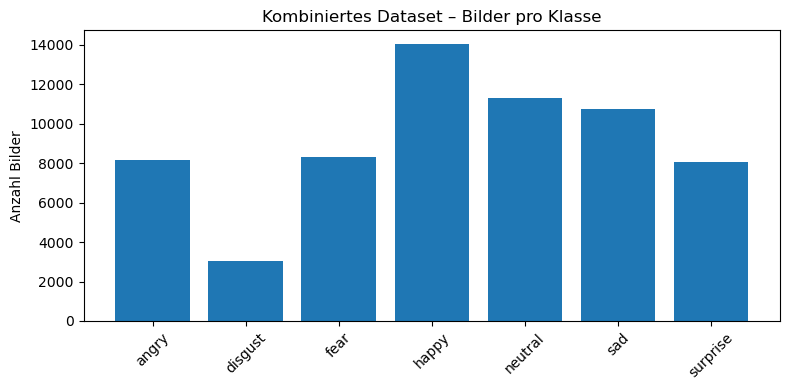

In [14]:
COMBINED_ROOT = "Combined_48x48"

EMOTIONS = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

def count_and_plot_combined(dataset_root=COMBINED_ROOT, emotions=EMOTIONS):
    counts = defaultdict(int)

    for emo in emotions:
        folder = os.path.join(dataset_root, emo)
        if not os.path.isdir(folder):
            print(f"[WARN] Ordner existiert nicht: {folder}")
            continue

        for fname in os.listdir(folder):
            if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                counts[emo] += 1

    # Ausgabe in der Konsole
    print("=== Anzahl Bilder pro Klasse (kombiniertes Dataset) ===")
    values = []
    for emo in emotions:
        v = counts[emo]
        values.append(v)
        print(f"{emo:9s}: {v}")
    print("\nGesamtanzahl Bilder:", sum(values))

    # Plot
    x = np.arange(len(emotions))
    plt.figure(figsize=(8, 4))
    plt.bar(x, values)
    plt.xticks(x, emotions, rotation=45)
    plt.ylabel("Anzahl Bilder")
    plt.title("Kombiniertes Dataset – Bilder pro Klasse")
    plt.tight_layout()
    plt.show()

    return counts


# Aufruf
counts_combined = count_and_plot_combined()

Wie im ersten Dataset berets erkannt, haben wir nur wenige "Disgust"-Samples. Daher werden wir diese Klasse später augmentieren.

<h3> Beispielbilder pro Klasse

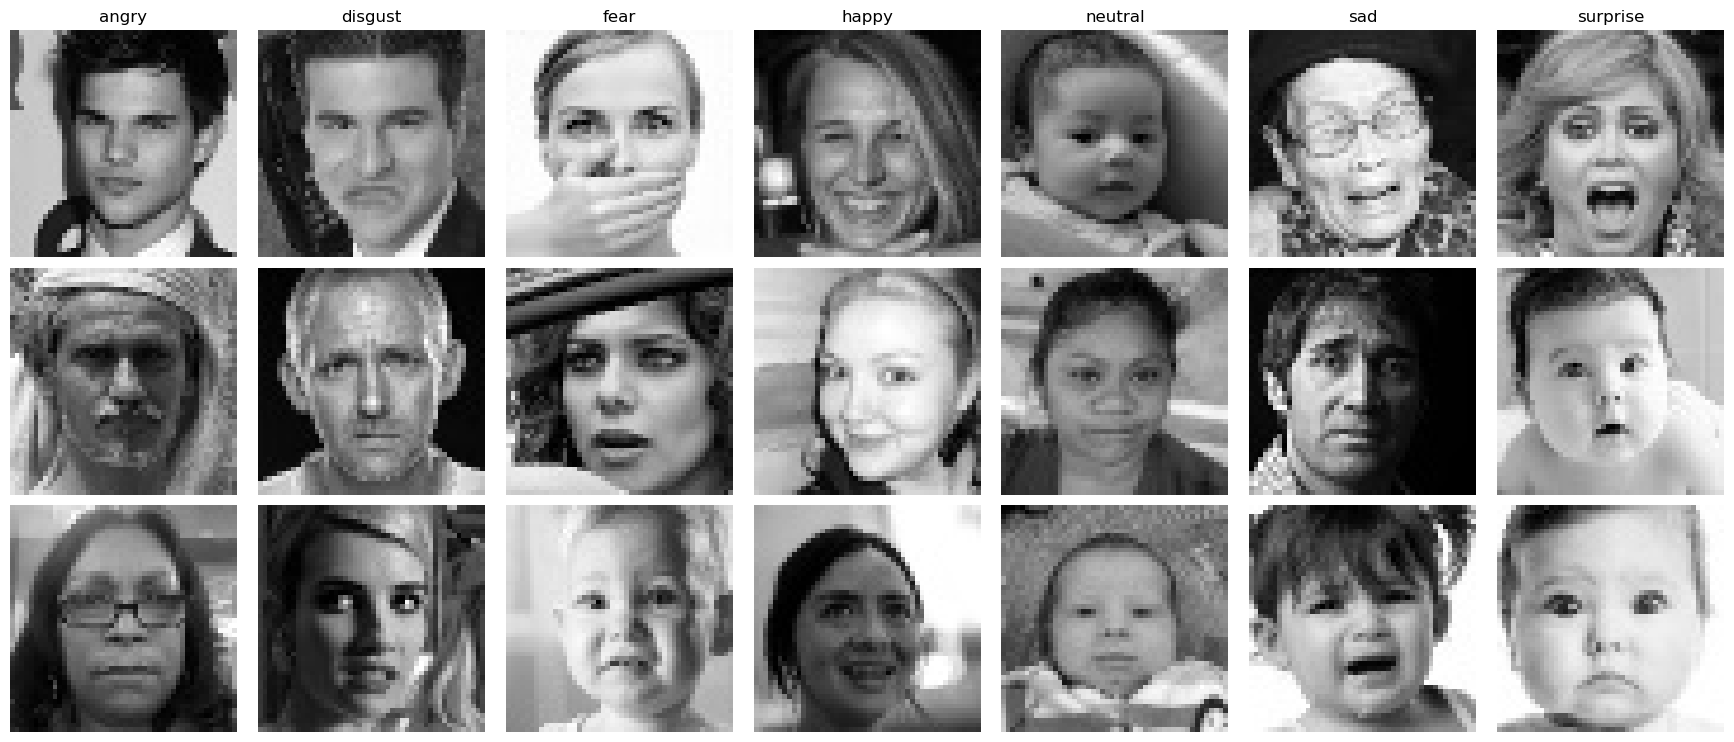

In [15]:
def get_example_paths(dataset_root=COMBINED_ROOT, emotions=EMOTIONS, n_examples=3):
    examples = {}

    for emo in emotions:
        folder = os.path.join(dataset_root, emo)
        files = [f for f in os.listdir(folder)
                 if f.lower().endswith((".jpg", ".jpeg", ".png"))]

        examples[emo] = [os.path.join(folder, f) for f in files[:n_examples]]

    return examples


def plot_examples_7x3(examples, grayscale=True):
    emotions = EMOTIONS
    n_classes = len(emotions)      # 7
    n_examples = 3                 # 3 rows

    plt.figure(figsize=(n_classes * 2.5, n_examples * 2.5))

    for col, emo in enumerate(emotions):
        paths = examples[emo]

        for row, path in enumerate(paths):
            img = cv2.imread(path)
            if grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(n_examples, n_classes, row * n_classes + col + 1)
            plt.imshow(img, cmap="gray" if grayscale else None)
            plt.axis("off")

            if row == 0:
                plt.title(emo, fontsize=12)

    plt.tight_layout()
    plt.show()


examples = get_example_paths()
plot_examples_7x3(examples)

Wie erwartet sind alle Bilder nun 48 x 48 Bilder groß.

<h2> Kombiniertes Dataset bereinigen

<h3> Dopplungen im Dataset finden und entfernen

Die beiden Datasets enhalten Dopplungen. Das liegt zum einen daran, dass die beiden Datasets teils die selben Quellen gecrawled haben.

Zum anderen wurden auch Videos gecrawled, wodurch hintereinander liegende Frames des Videos das selbe Bild erzeugen können.

Die sehr ähnlichen Bilder werden über einen perceptual hash (pHash) gefunden. Dabei wird nicht der Dateiname oder die Pixel 1:1 verglichen, sondern jedes Bild wird auf eine kleine, vereinheitlichte Darstellung reduziert, aus der ein Hash berechnet wird, der den visuellen Inhalt des Bildes widerspiegelt. Zwei Bilder, die nahezu gleich aussehen – selbst wenn sie unterschiedliche Dateinamen, Kompression oder minimale Pixelabweichungen haben – erzeugen dabei denselben oder einen sehr ähnlichen Hashwert.

Im Code wird für jedes Bild im kombinierten Dataset dieser pHash erstellt und in einer Hash-Tabelle abgelegt. Wenn mehrere Bilder denselben Hash besitzen, erscheinen sie in derselben Gruppe und gelten als „sehr ähnlich“. Das Verfahren nutzt also keine reine Pixelgleichheit, sondern eine robuste Bildähnlichkeitsmessung. Dadurch findet es nicht nur exakte Duplikate, sondern auch mehrfach vorkommende, leicht veränderte Versionen desselben Bildes – zum Beispiel unterschiedliche Helligkeiten, Crops oder Kompressionsartefakte.

🔎 Berechne Perceptual Hashes...
Gefundene Hash-Gruppen mit >= 2 Bildern: 3596

Gruppe 1 (Anzahl: 4):
   Combined_48x48\angry\ANET_1003.jpg
   Combined_48x48\angry\ANET_1184.jpg
   Combined_48x48\angry\ANET_1255.jpg
   Combined_48x48\angry\ANET_807.jpg

Gruppe 2 (Anzahl: 2):
   Combined_48x48\angry\ANET_1014.jpg
   Combined_48x48\angry\ANET_1480.jpg

Gruppe 3 (Anzahl: 3):
   Combined_48x48\angry\ANET_1051.jpg
   Combined_48x48\angry\ANET_15072.jpg
   Combined_48x48\angry\ANET_15486.jpg


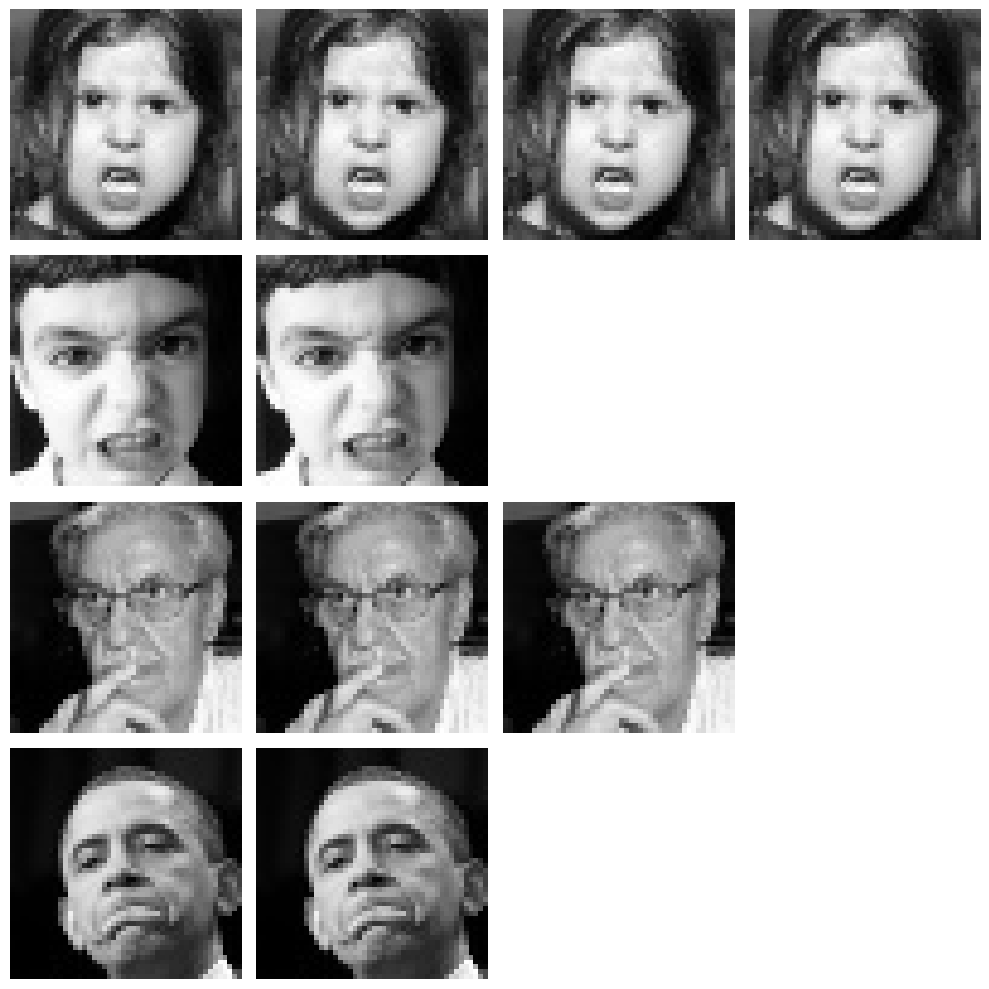

Gesamtbilder: 63642
Davon Dopplungen (werden gelöscht): 4290
Einzigartige Bilder nach Bereinigung: 59352


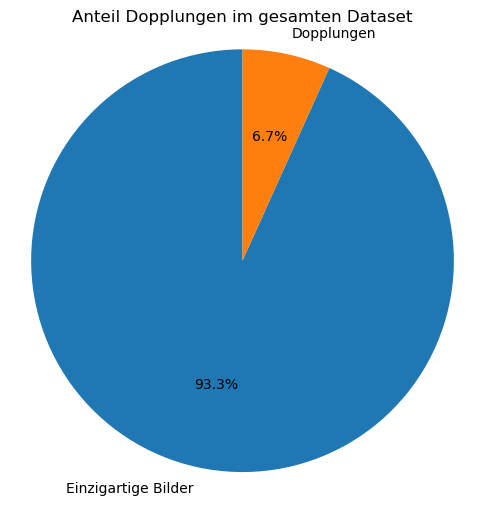

Es wurden 4290 Dateien als Dopplungen identifiziert.
Beispiel (erste 10):
   Combined_48x48\angry\ANET_1184.jpg
   Combined_48x48\angry\ANET_1255.jpg
   Combined_48x48\angry\ANET_807.jpg
   Combined_48x48\angry\ANET_1480.jpg
   Combined_48x48\angry\ANET_15072.jpg
   Combined_48x48\angry\ANET_15486.jpg
   Combined_48x48\sad\ANET_11515.jpg
   Combined_48x48\angry\ANET_15024.jpg
   Combined_48x48\surprise\ANET_12885.jpg
   Combined_48x48\disgust\ANET_2054.jpg
Löschen abgeschlossen. 4290 Dateien wurden entfernt.


In [17]:
COMBINED_ROOT = "Combined_48x48"  # <- ggf. anpassen

# =========================================================
# Hilfsfunktionen
# =========================================================

def iter_image_paths(root=COMBINED_ROOT):
    """
    Iteriert über alle Bilder im kombinierten Dataset.
    Erwartete Struktur: root / <label> / *.jpg|png|...
    Gibt (label, path) zurück.
    """
    for label in sorted(os.listdir(root)):
        label_dir = os.path.join(root, label)
        if not os.path.isdir(label_dir):
            continue

        for fname in os.listdir(label_dir):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                continue

            yield label, os.path.join(label_dir, fname)


def ahash_image(path, hash_size=8):
    """
    Einfacher Perceptual Hash (Average Hash).
    - Bild in Graustufen konvertieren
    - auf hash_size x hash_size skalieren
    - Hash = Pixel > Durchschnitt
    """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    img = cv2.resize(img, (hash_size, hash_size), interpolation=cv2.INTER_AREA)
    avg = img.mean()
    diff = img > avg
    return diff.flatten()


def hash_to_key(h):
    """Bool-Array -> String-Key."""
    return "".join("1" if x else "0" for x in h)


def find_perceptual_duplicates(root=COMBINED_ROOT, hash_size=8, min_group_size=2, max_print_groups=5):
    """
    Sucht (nahe) Duplikate über einen einfachen Average-Hash.
    - Gruppiert Bilder mit gleichem Hash
    - Gibt Gruppen mit mindestens min_group_size Bildern zurück
    """
    phash_dict = defaultdict(list)

    print("🔎 Berechne Perceptual Hashes...")
    for label, path in iter_image_paths(root):
        h = ahash_image(path, hash_size=hash_size)
        if h is None:
            continue
        key = hash_to_key(h)
        phash_dict[key].append(path)

    duplicate_groups = [paths for paths in phash_dict.values() if len(paths) >= min_group_size]

    print(f"Gefundene Hash-Gruppen mit >= {min_group_size} Bildern:", len(duplicate_groups))

    # Optional: ein paar Gruppen im Terminal anzeigen
    for i, group in enumerate(duplicate_groups[:max_print_groups]):
        print(f"\nGruppe {i+1} (Anzahl: {len(group)}):")
        for p in group:
            print("  ", p)

    return duplicate_groups


def plot_duplicate_groups(dup_groups, max_groups=5, grayscale=True):
    """
    Plottet jede Duplicate-Gruppe in einer eigenen Zeile.
    max_groups: Wie viele Gruppen sollen geplottet werden?
    """
    if not dup_groups:
        print("Keine Duplikat-Gruppen zum Plotten gefunden.")
        return

    groups_to_plot = dup_groups[:max_groups]   # z.B. nur erste 5 Gruppen anzeigen

    n_groups = len(groups_to_plot)
    max_group_size = max(len(g) for g in groups_to_plot)

    plt.figure(figsize=(max_group_size * 2.5, n_groups * 2.5))

    img_id = 1

    for row, group in enumerate(groups_to_plot):
        for col, path in enumerate(group):
            img = cv2.imread(path)

            if grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                cmap = "gray"
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                cmap = None

            plt.subplot(n_groups, max_group_size, img_id)
            plt.imshow(img, cmap=cmap)
            plt.axis("off")

            # Titel nur oben der Reihe
            if col == 0:
                plt.ylabel(f"Gruppe {row+1}", rotation=0,
                           labelpad=40, fontsize=12, va="center")

            img_id += 1

        # Falls Gruppe weniger Bilder hat, die restlichen Subplots leer lassen
        missing = max_group_size - len(group)
        for _ in range(missing):
            plt.subplot(n_groups, max_group_size, img_id)
            plt.axis("off")
            img_id += 1

    plt.tight_layout()
    plt.show()


# =========================================================
# NEU: Pie-Chart über Dopplungen
# =========================================================

def plot_duplicate_pie(dup_groups, root=COMBINED_ROOT):
    """
    Erstellt ein Pie-Chart, das zeigt, wie viele Dopplungen im Dataset sind.
    Dabei gilt:
    - Pro Duplikat-Gruppe wird 1 Bild als "Original" behalten.
    - Alle weiteren Bilder der Gruppe zählen als Dopplungen.
    """
    # Gesamtanzahl Bilder im Dataset
    total_images = sum(1 for _ in iter_image_paths(root))

    # Anzahl Bilder, die als Dopplungen gelten (alle außer je 1 Bild pro Gruppe)
    duplicates_to_delete = sum(max(0, len(g) - 1) for g in dup_groups)

    unique_images = total_images - duplicates_to_delete

    print(f"Gesamtbilder: {total_images}")
    print(f"Davon Dopplungen (werden gelöscht): {duplicates_to_delete}")
    print(f"Einzigartige Bilder nach Bereinigung: {unique_images}")

    labels = ["Einzigartige Bilder", "Dopplungen"]
    sizes = [unique_images, duplicates_to_delete]

    plt.figure(figsize=(6, 6))
    plt.pie(
        sizes,
        labels=labels,
        autopct="%1.1f%%",
        startangle=90
    )
    plt.title("Anteil Dopplungen im gesamten Dataset")
    plt.axis("equal")  # Kreis
    plt.show()


# =========================================================
# NEU: Duplikate löschen
# =========================================================

def delete_perceptual_duplicates(dup_groups, keep_index=0, dry_run=False):
    """
    Löscht alle Dopplungen/Mehrfachungen.
    - pro Duplikat-Gruppe bleibt genau 1 Bild übrig (das nach Sortierung an Position keep_index)
    - alle anderen werden gelöscht
    """
    files_to_delete = []

    for group in dup_groups:
        if len(group) <= 1:
            continue

        # Sortieren für deterministisches Verhalten
        group_sorted = sorted(group)
        # Bild, das behalten wird
        if keep_index >= len(group_sorted):
            keep_index = 0  # fallback
        to_keep = group_sorted[keep_index]

        # alle anderen löschen
        for p in group_sorted:
            if p == to_keep:
                continue
            files_to_delete.append(p)

    print(f"Es wurden {len(files_to_delete)} Dateien als Dopplungen identifiziert.")
    print("Beispiel (erste 10):")
    for p in files_to_delete[:10]:
        print("  ", p)

    if dry_run:
        print("Dry-Run aktiv – es wurde noch nichts gelöscht.")
        return

    # Jetzt wirklich löschen
    deleted = 0
    for p in files_to_delete:
        try:
            os.remove(p)
            deleted += 1
        except FileNotFoundError:
            print(f"Schon gelöscht oder nicht gefunden: {p}")

    print(f"Löschen abgeschlossen. {deleted} Dateien wurden entfernt.")


# =========================================================
# Ausführung
# =========================================================

# 1. Duplikate per Perceptual Hash finden
perceptual_dups = find_perceptual_duplicates(
    root=COMBINED_ROOT,
    hash_size=8,
    min_group_size=2,
    max_print_groups=3,
)

# 2. Einige Gruppen im Plot anzeigen
plot_duplicate_groups(perceptual_dups, max_groups=4, grayscale=True)

# 3. Pie-Chart: Anteil Dopplungen im gesamten Datensatz
plot_duplicate_pie(perceptual_dups, root=COMBINED_ROOT)

# 4. Alle Dopplungen/Mehrfachungen löschen
#    Achtung: dry_run=False bedeutet, dass wirklich gelöscht wird.
delete_perceptual_duplicates(perceptual_dups, keep_index=0, dry_run=False)

Es gab also 3596 Duplikatgruppen mit insgesamt 4290 Duplikaten, die nun gelöscht wurden.

<h3> Schwarze/Weiße Bilder entfernen

Wie wir in der Analyse gesehen haben, gibt es Bilder, die kein Gesicht enthalten, sondern einfach schwarz sind. Diese werden wir nun finden und löschen.

🔎 Suche nach fast komplett schwarzen/weißen Bildern...
Gefundene fast schwarze Bilder : 1
Gefundene fast weiße   Bilder : 0
Summe (werden potenziell gelöscht): 1


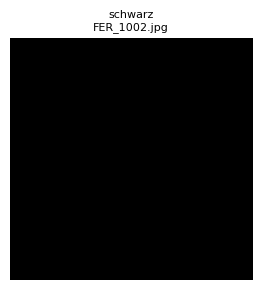

Insgesamt 1 Dateien zum Löschen markiert.
Beispiele (erste 10):
   Combined_48x48\angry\FER_1002.jpg
Löschen abgeschlossen. 1 Dateien wurden entfernt.


In [19]:
def iter_image_paths(root=COMBINED_ROOT):
    """
    Wie oben: Iteriert über alle Bilder im kombinierten Dataset.
    """
    for label in sorted(os.listdir(root)):
        label_dir = os.path.join(root, label)
        if not os.path.isdir(label_dir):
            continue

        for fname in os.listdir(label_dir):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                continue

            yield label, os.path.join(label_dir, fname)


# =========================================================
# 1) Schwarze / weiße Bilder finden
# =========================================================

def find_black_white_images(
    root=COMBINED_ROOT,
    black_thresh=5,
    white_thresh=250,
    min_fraction=0.999
):
    """
    Findet Bilder, die praktisch komplett schwarz oder komplett weiß sind.

    - Bild wird in Graustufen geladen.
    - 'Schwarz': mind. min_fraction der Pixel <= black_thresh
    - 'Weiß' : mind. min_fraction der Pixel >= white_thresh

    Rückgabe:
        black_images: Liste von Pfaden fast schwarzer Bilder
        white_images: Liste von Pfaden fast weißer Bilder
    """
    black_images = []
    white_images = []

    print("🔎 Suche nach fast komplett schwarzen/weißen Bildern...")

    for label, path in iter_image_paths(root):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # Normal als uint8 0-255
        total_pixels = img.size

        black_fraction = np.sum(img <= black_thresh) / total_pixels
        white_fraction = np.sum(img >= white_thresh) / total_pixels

        if black_fraction >= min_fraction:
            black_images.append(path)
        elif white_fraction >= min_fraction:
            white_images.append(path)

    print(f"Gefundene fast schwarze Bilder : {len(black_images)}")
    print(f"Gefundene fast weiße   Bilder : {len(white_images)}")
    print(f"Summe (werden potenziell gelöscht): {len(black_images) + len(white_images)}")

    return black_images, white_images


# =========================================================
# 2) Beispiele plotten
# =========================================================

def plot_black_white_examples(black_images, white_images, max_examples=16):
    """
    Plottet einige Beispiele der gefundenen schwarz/weißen Bilder.
    """
    all_examples = []

    # erst schwarze, dann weiße – bis max_examples voll ist
    for p in black_images:
        if len(all_examples) >= max_examples:
            break
        all_examples.append(("schwarz", p))

    for p in white_images:
        if len(all_examples) >= max_examples:
            break
        all_examples.append(("weiß", p))

    if not all_examples:
        print("Keine Beispiele zum Plotten gefunden.")
        return

    n = len(all_examples)
    cols = min(4, n)
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols * 3, rows * 3))

    for i, (kind, path) in enumerate(all_examples, start=1):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"{kind}\n{os.path.basename(path)}", fontsize=8)

    plt.tight_layout()
    plt.show()


# =========================================================
# 3) Bilder löschen
# =========================================================

def delete_images(image_paths, dry_run=False):
    """
    Löscht alle Bilder in image_paths.
    Wenn dry_run=True, wird nur angezeigt, was gelöscht würde.
    """
    print(f"Insgesamt {len(image_paths)} Dateien zum Löschen markiert.")

    print("Beispiele (erste 10):")
    for p in image_paths[:10]:
        print("  ", p)

    if dry_run:
        print("Dry-Run aktiv – es wurde noch nichts gelöscht.")
        return

    deleted = 0
    for p in image_paths:
        try:
            os.remove(p)
            deleted += 1
        except FileNotFoundError:
            print(f"Schon gelöscht oder nicht gefunden: {p}")
        except Exception as e:
            print(f"Fehler beim Löschen von {p}: {e}")

    print(f"Löschen abgeschlossen. {deleted} Dateien wurden entfernt.")


# =========================================================
# Ausführung
# =========================================================

# 1) Schwarze / weiße Bilder finden
black_imgs, white_imgs = find_black_white_images(
    root=COMBINED_ROOT,
    black_thresh=5,     # Pixel <= 5 zählen als "schwarz"
    white_thresh=250,   # Pixel >= 250 zählen als "weiß"
    min_fraction=0.999  # mind. 99,9% der Pixel müssen so sein
)

# 2) Einige Beispiele plotten
plot_black_white_examples(black_imgs, white_imgs, max_examples=16)

# 3) Bilder löschen (dry_run=True zum Testen)
delete_images(black_imgs + white_imgs, dry_run=False)

Es wurde nur ein schwarzes Bild gefunden und gelöscht.

<h2> Augmentieren

Da die Klasse "disgust" deutlcih weniger Samples hat als die anderen Klassen, augmentieren wir die Bilder dieser Klasse.
Wir nutzen jeweils zufällig einen der folgenden Augemntierungsarten 
- leichte Rotation
- leichten x-y- shift
- horizontalen Flip
- leichten noise hinzufügen
- Helligkeitswerte leicht variieren

und verdreifachen so die Samplesize der Klasse.

Die Augmentierungsarten werden visualisiert.


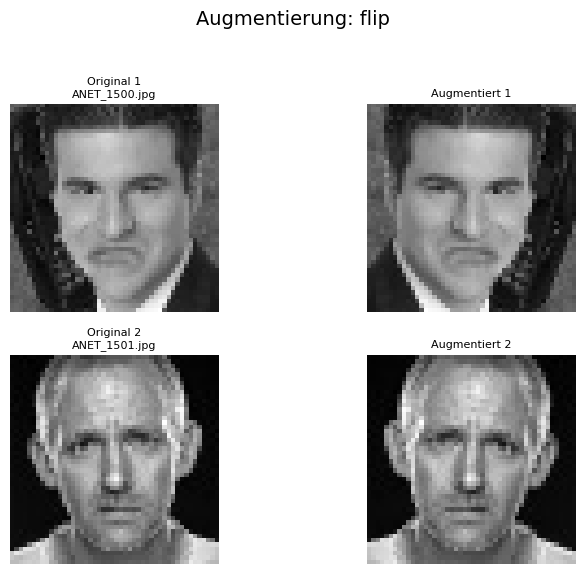

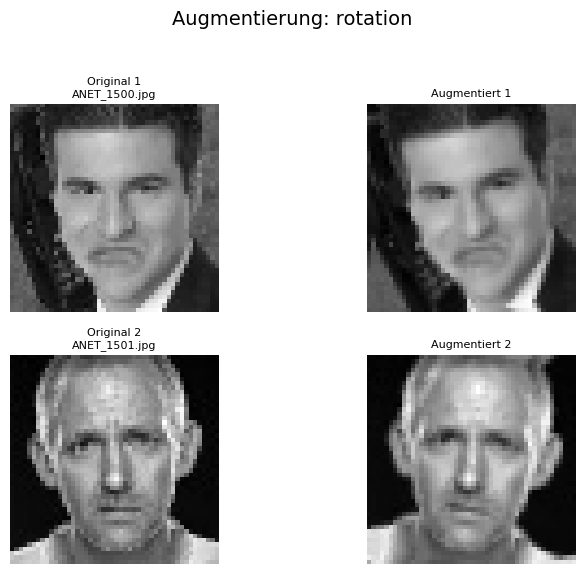

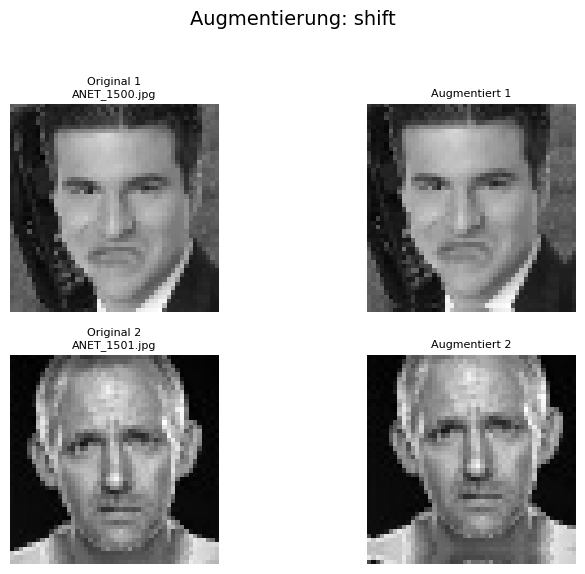

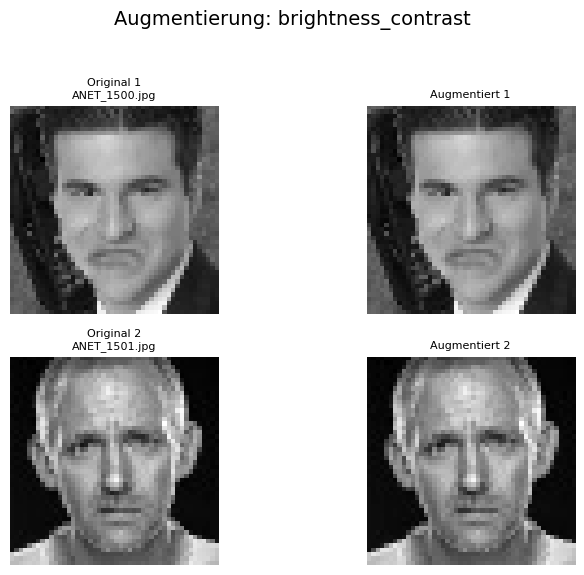

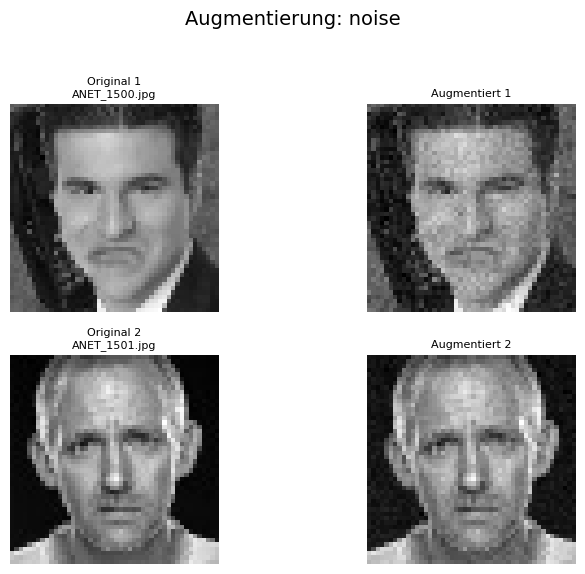

Klasse 'disgust': 2827 Originalbilder.
Ziel: 8481 Bilder (Faktor 3).
Es werden 5654 neue augmentierte Bilder erzeugt.
Augmentierung abgeschlossen. 5654 neue Bilder wurden erzeugt.
Erwartete Gesamtanzahl in 'disgust': 8481.


In [23]:
COMBINED_ROOT = "Combined_48x48"
DISGUST_LABEL = "disgust"

# Falls du iter_image_paths schon definiert hast, kannst du die Funktion unten weglassen.
def iter_image_paths(root=COMBINED_ROOT):
    for label in sorted(os.listdir(root)):
        label_dir = os.path.join(root, label)
        if not os.path.isdir(label_dir):
            continue

        for fname in os.listdir(label_dir):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                continue

            yield label, os.path.join(label_dir, fname)


# ===================================================================
# 1) Bilder der Klasse "disgust" einsammeln
# ===================================================================

def get_class_image_paths(root=COMBINED_ROOT, class_name=DISGUST_LABEL):
    paths = []
    for label, path in iter_image_paths(root):
        if label == class_name:
            paths.append(path)
    return sorted(paths)


# ===================================================================
# 2) Augmentierungen definieren (für 48x48 Graustufen-Gesichter)
# ===================================================================

def aug_hflip(img):
    """Horizontaler Flip."""
    return cv2.flip(img, 1)


def aug_small_rotation(img, max_angle=10):
    """Kleine Rotation (−max_angle .. +max_angle Grad)."""
    h, w = img.shape[:2]
    angle = random.uniform(-max_angle, max_angle)
    M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_REFLECT_101)
    return rotated


def aug_shift(img, max_shift=4):
    """Kleine Translation in x/y-Richtung."""
    h, w = img.shape[:2]
    tx = random.randint(-max_shift, max_shift)
    ty = random.randint(-max_shift, max_shift)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    shifted = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_REFLECT_101)
    return shifted


def aug_brightness_contrast(img, alpha_range=(0.8, 1.2), beta_range=(-20, 20)):
    """
    Leichte Änderung von Helligkeit/Kontrast.
    alpha ~ Kontrast, beta ~ Helligkeit.
    """
    alpha = random.uniform(*alpha_range)
    beta = random.uniform(*beta_range)
    aug = img.astype(np.float32) * alpha + beta
    aug = np.clip(aug, 0, 255).astype(np.uint8)
    return aug


def aug_gaussian_noise(img, sigma_range=(5, 15)):
    """Leichtes Gauß-Rauschen hinzufügen."""
    sigma = random.uniform(*sigma_range)
    noise = np.random.normal(0, sigma, img.shape).astype(np.float32)
    aug = img.astype(np.float32) + noise
    aug = np.clip(aug, 0, 255).astype(np.uint8)
    return aug


AUGMENTATIONS = {
    "flip": aug_hflip,
    "rotation": aug_small_rotation,
    "shift": aug_shift,
    "brightness_contrast": aug_brightness_contrast,
    "noise": aug_gaussian_noise,
}


# ===================================================================
# 3) Beispiele plotten – für jede Augmentierung 2 Bilder + Augmentierung
# ===================================================================

def plot_augmentation_examples_for_class(
    root=COMBINED_ROOT,
    class_name=DISGUST_LABEL,
    augmentations=AUGMENTATIONS,
    num_examples=2
):
    paths = get_class_image_paths(root, class_name)
    if len(paths) == 0:
        print(f"Keine Bilder für Klasse '{class_name}' gefunden.")
        return

    example_paths = paths[:num_examples]

    for aug_name, aug_fn in augmentations.items():
        plt.figure(figsize=(8, 6))
        plt.suptitle(f"Augmentierung: {aug_name}", fontsize=14)

        for i, path in enumerate(example_paths):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            aug_img = aug_fn(img)

            # Original
            plt.subplot(num_examples, 2, 2 * i + 1)
            plt.imshow(img, cmap="gray")
            plt.axis("off")
            plt.title(f"Original {i+1}\n{os.path.basename(path)}", fontsize=8)

            # Augmentiert
            plt.subplot(num_examples, 2, 2 * i + 2)
            plt.imshow(aug_img, cmap="gray")
            plt.axis("off")
            plt.title(f"Augmentiert {i+1}", fontsize=8)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


# ===================================================================
# 4) Klasse "disgust" bis Faktor 3 augmentieren
# ===================================================================

def augment_disgust_to_factor(
    root=COMBINED_ROOT,
    class_name=DISGUST_LABEL,
    target_factor=3,
    augmentations=AUGMENTATIONS
):
    paths = get_class_image_paths(root, class_name)
    n_original = len(paths)
    if n_original == 0:
        print(f"Keine Originalbilder für Klasse '{class_name}' gefunden.")
        return

    target_count = n_original * target_factor
    num_to_add = target_count - n_original

    if num_to_add <= 0:
        print(f"Klasse '{class_name}' hat bereits >= {target_factor}x Samples.")
        return

    print(f"Klasse '{class_name}': {n_original} Originalbilder.")
    print(f"Ziel: {target_count} Bilder (Faktor {target_factor}).")
    print(f"Es werden {num_to_add} neue augmentierte Bilder erzeugt.")

    class_dir = os.path.join(root, class_name)

    aug_names = list(augmentations.keys())
    random.shuffle(paths)  # etwas durchmischen, damit nicht immer dieselben zuerst

    created = 0
    idx = 0

    while created < num_to_add:
        base_path = paths[idx % n_original]
        img = cv2.imread(base_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            idx += 1
            continue

        aug_name = random.choice(aug_names)
        aug_fn = augmentations[aug_name]
        aug_img = aug_fn(img)

        base_name, ext = os.path.splitext(os.path.basename(base_path))
        new_fname = f"{base_name}_aug_{aug_name}_{created}{ext}"
        new_path = os.path.join(class_dir, new_fname)

        # Falls selten ein Name kollidiert
        counter = 1
        while os.path.exists(new_path):
            new_fname = f"{base_name}_aug_{aug_name}_{created}_{counter}{ext}"
            new_path = os.path.join(class_dir, new_fname)
            counter += 1

        cv2.imwrite(new_path, aug_img)
        created += 1
        idx += 1

    print(f"Augmentierung abgeschlossen. {created} neue Bilder wurden erzeugt.")
    print(f"Erwartete Gesamtanzahl in '{class_name}': {n_original + created}.")


# ===================================================================
# Ausführung
# ===================================================================

# 1) Beispiele für jede Augmentierung anzeigen (2 Bilder + Augmentierung)
plot_augmentation_examples_for_class(
    root=COMBINED_ROOT,
    class_name=DISGUST_LABEL,
    augmentations=AUGMENTATIONS,
    num_examples=2,
)

# 2) Klasse "disgust" auf 3x vergrößern
augment_disgust_to_factor(
    root=COMBINED_ROOT,
    class_name=DISGUST_LABEL,
    target_factor=3,
    augmentations=AUGMENTATIONS,
)


Um zu überprüfen, ob die Samplesize von "disgust" nun wie erwünscht verdreifacht wurde, plotten wir uns nochmal die Anzahl aller Bilder aller Klassen.

=== Anzahl Bilder pro Klasse (kombiniertes Dataset) ===
angry    : 7853
disgust  : 8481
fear     : 7748
happy    : 13807
neutral  : 11131
sad      : 8851
surprise : 7134

Gesamtanzahl Bilder: 65005


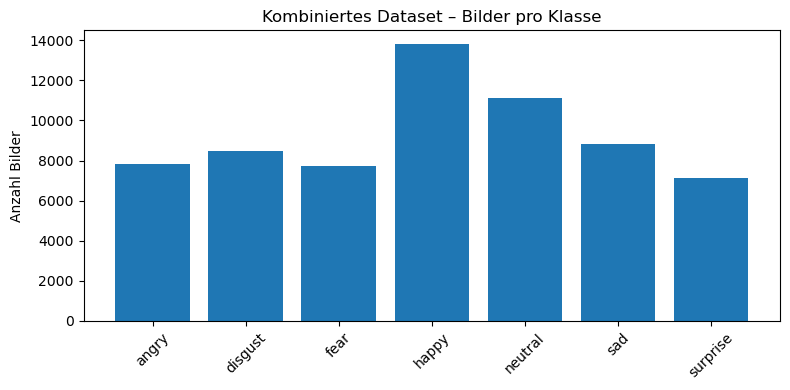

In [24]:
COMBINED_ROOT = "Combined_48x48"

EMOTIONS = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

def count_and_plot_combined(dataset_root=COMBINED_ROOT, emotions=EMOTIONS):
    counts = defaultdict(int)

    for emo in emotions:
        folder = os.path.join(dataset_root, emo)
        if not os.path.isdir(folder):
            print(f"[WARN] Ordner existiert nicht: {folder}")
            continue

        for fname in os.listdir(folder):
            if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                counts[emo] += 1

    # Ausgabe in der Konsole
    print("=== Anzahl Bilder pro Klasse (kombiniertes Dataset) ===")
    values = []
    for emo in emotions:
        v = counts[emo]
        values.append(v)
        print(f"{emo:9s}: {v}")
    print("\nGesamtanzahl Bilder:", sum(values))

    # Plot
    x = np.arange(len(emotions))
    plt.figure(figsize=(8, 4))
    plt.bar(x, values)
    plt.xticks(x, emotions, rotation=45)
    plt.ylabel("Anzahl Bilder")
    plt.title("Kombiniertes Dataset – Bilder pro Klasse")
    plt.tight_layout()
    plt.show()

    return counts


# Aufruf
counts_combined = count_and_plot_combined()

Wie man sieht, hat "disgust" nun nicht mehr deutlich weniger Samples als die anderen Klassen.

<h1> Daten fürs Training vorbereiten

Wir lesen alle Bilder, machen sicher, dass sie Graustufen 48×48 sind,
und bauen Arrays X (Bilder) und y (Labels).

In [30]:
DATA_ROOT = "Combined_48x48"
IMG_SIZE = (48, 48)
SEED = 42

def load_dataset_from_folders(root_dir=DATA_ROOT, img_size=IMG_SIZE):
    X = []
    y = []

    class_names = []
    # nur Ordner (Klassen) sammeln
    for name in sorted(os.listdir(root_dir)):
        path = os.path.join(root_dir, name)
        if os.path.isdir(path):
            class_names.append(name)

    print("Gefundene Klassen:", class_names)

    for label in class_names:
        class_dir = os.path.join(root_dir, label)
        for fname in os.listdir(class_dir):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                continue

            fpath = os.path.join(class_dir, fname)

            # Graustufen laden
            img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            # Sicherheit: Auf 48x48 bringen
            if img.shape != img_size:
                img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)

            X.append(img)
            y.append(label)

    X = np.array(X, dtype=np.uint8)
    y = np.array(y)

    print("Shape X (roh):", X.shape)
    print("Shape y:", y.shape)
    return X, y, class_names

X, y, class_names = load_dataset_from_folders()


Gefundene Klassen: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Shape X (roh): (65005, 48, 48)
Shape y: (65005,)


Normieren und Train/Val/Test spliiten

In [31]:
# Bilder auf [0,1] normieren und Channel-Dimension hinzufügen
X = X.astype("float32") / 255.0
X = np.expand_dims(X, axis=-1)  # (N, 48, 48, 1)

# Labels encoden
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y)           
y_cat = to_categorical(y_int)                   # One-Hot

num_classes = len(class_names)
print("Anzahl Klassen:", num_classes)
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Train / Test / Validation Split (70% / 15% / 15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_cat, test_size=0.15, random_state=SEED, stratify=y_cat
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=SEED, stratify=y_temp
)  # 0.1765 von 85% ~ 15% gesamt

print("Train-Shape:", X_train.shape, y_train.shape)
print("Val-Shape  :", X_val.shape, y_val.shape)
print("Test-Shape :", X_test.shape, y_test.shape)

Anzahl Klassen: 7
Label Mapping: {np.str_('angry'): np.int64(0), np.str_('disgust'): np.int64(1), np.str_('fear'): np.int64(2), np.str_('happy'): np.int64(3), np.str_('neutral'): np.int64(4), np.str_('sad'): np.int64(5), np.str_('surprise'): np.int64(6)}
Train-Shape: (45501, 48, 48, 1) (45501, 7)
Val-Shape  : (9753, 48, 48, 1) (9753, 7)
Test-Shape : (9751, 48, 48, 1) (9751, 7)


<h1> Test-CNN

Im folgenden wird ein Test CNN traniert, um zu prüfen, ob sich die Daten in der gegenwärtigen Form eignen.
Ziel ist es, eine Verbesserung in der Accuracy über die Epochen hinweg zuzehen und eine Accuracy über der zufallsbaseline (1/7) zu haben.

CNN definieren

In [35]:
def build_emotion_cnn_1(input_shape=(48, 48, 1), num_classes=7):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

model = build_emotion_cnn_1(input_shape=(48, 48, 1), num_classes=num_classes)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,390,951 (9.12 MB)

 Trainable params: 2,390,183 (9.12 MB)

 Non-trainable params: 768 (3.00 KB)

CNN kompilieren und trainieren

In [43]:
MODEL_PATH = "../models/emotion_cnn_model_POC.keras"

if os.path.exists(MODEL_PATH):
    print("✔ Modell gefunden – lade gespeichertes Modell.")
    model = load_model(MODEL_PATH)

else:
    print("❌ Modell nicht gefunden – trainiere jetzt neu.")
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    epochs = 10
    batch_size = 64

    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        shuffle=True
    )

    # Speichern
    os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
    model.save(MODEL_PATH)
    print(f"✔ Modell gespeichert unter: {MODEL_PATH}")

✔ Modell gefunden – lade gespeichertes Modell.


Accuracy testen

In [44]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"🎯 Test Accuracy: {accuracy:.4f}")
print(f"📉 Test Loss:     {loss:.4f}")


🎯 Test Accuracy: 0.5795
📉 Test Loss:     1.2286


Die Accuracy liegt deutlich über der Zufallsbaseline (1/7). Das zeigt, dass sich die Daten für eine Klassifizierung eignen. Durch Verbesserung der Architektur und Hyperparameter kann die Accuracy weiter verbessert werden.